In [2]:
import numpy as np
import tensorflow as tf
import os
from glob import glob
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

print(tf.__version__)

2.4.1


In [3]:
from google.colab import drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "gdrive/My Drive/chest_xray"

test  train  val


In [5]:
BASE_DIR=('gdrive/My Drive/chest_xray/')

In [6]:
train_dir = os.path.join(BASE_DIR,'train/')
val_dir = os.path.join(BASE_DIR,'val/')
test_dir = os.path.join(BASE_DIR,'test/')

print('Number of images in training set = ',str(len(glob(train_dir+'*/*'))))
print('Number of images in validation set = ',str(len(glob(val_dir+'*/*'))))
print('Number of images in testing set = ',str(len(glob(test_dir+'*/*'))))

Number of images in training set =  4335
Number of images in validation set =  782
Number of images in testing set =  782


In [ ]:
train_normal_files = os.listdir(os.path.join(train_dir,'NORMAL/'))
train_pneumonia_files = os.listdir(os.path.join(train_dir,'PNEUMONIA/'))

print(train_normal_files[:10])
print(train_pneumonia_files[:10])

['IM-0355-0001.jpeg', 'IM-0325-0001.jpeg', 'IM-0337-0001.jpeg', 'IM-0338-0001.jpeg', 'IM-0320-0001.jpeg', 'IM-0324-0001.jpeg', 'IM-0359-0001.jpeg', 'IM-0350-0001.jpeg', 'IM-0351-0001.jpeg', 'IM-0319-0001.jpeg']
['person508_virus_1020.jpeg', 'person544_virus_1080.jpeg', 'person500_bacteria_2111.jpeg', 'person520_bacteria_2205.jpeg', 'person535_bacteria_2256.jpeg', 'person519_virus_1038.jpeg', 'person491_bacteria_2082.jpeg', 'person518_bacteria_2199.jpeg', 'person493_bacteria_2086.jpeg', 'person535_bacteria_2255.jpeg']


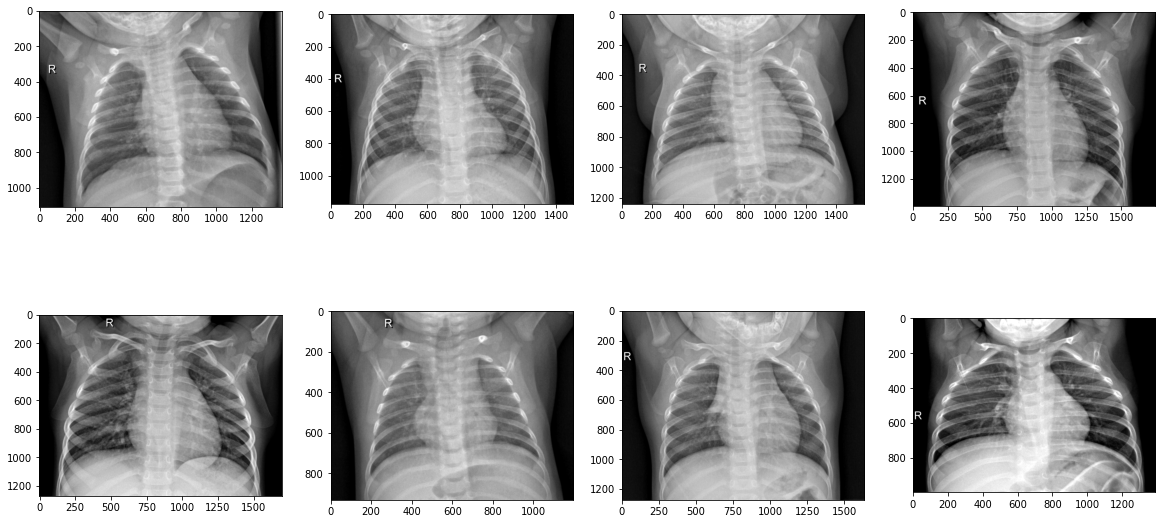

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

no_cols=4
no_rows=2

fig=plt.gcf()
fig.set_size_inches(no_cols*5,no_rows*5)

picture_index = 8

normal_pictures =[os.path.join(os.path.join(train_dir,'NORMAL/'),file) for file in train_normal_files[picture_index-8:picture_index]]

for i,img_path in enumerate(normal_pictures):
    sp=plt.subplot(no_rows,no_cols,i+1)
    sp.axis()
    img=mpimg.imread(img_path)
    plt.imshow(img,cmap='gray')
    
plt.show()

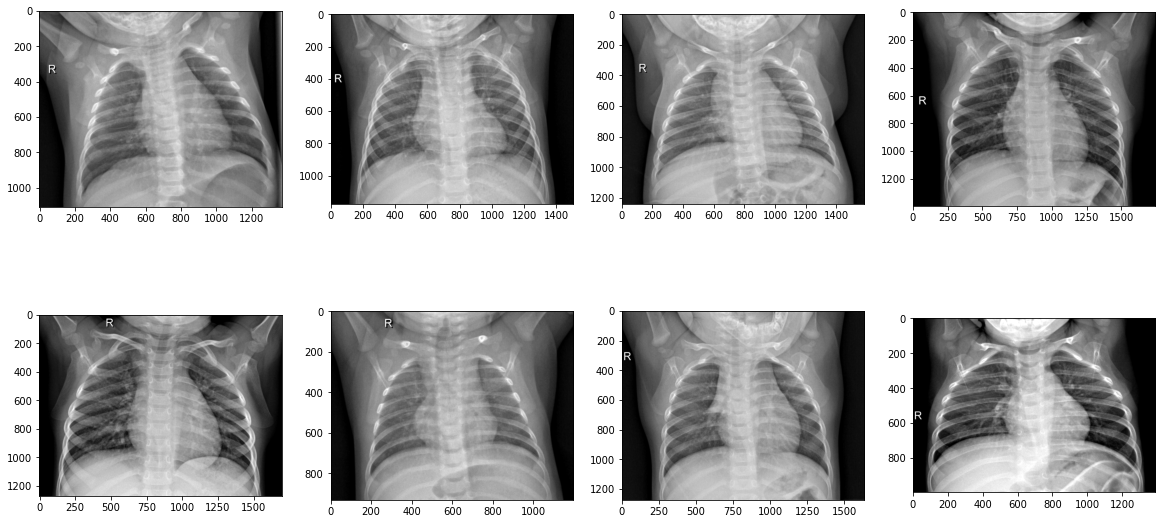

In [ ]:
pneumonia_pictures =[os.path.join(os.path.join(train_dir,'NORMAL/'),file) for file in train_normal_files[picture_index-8:picture_index]]

fig=plt.gcf()
fig.set_size_inches(no_cols*5,no_rows*5)

for i,img_path in enumerate(pneumonia_pictures):
    sp=plt.subplot(no_rows,no_cols,i+1)
    sp.axis()
    img=mpimg.imread(img_path)
    plt.imshow(img,cmap='gray')
    
plt.show()

# Vlastiti modeli

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',padding='same', input_shape=(180, 180, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), 
                       tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

In [ ]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.1,
                                 )

In [ ]:
val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(train_dir, color_mode="grayscale",target_size=(180,180),batch_size=128,class_mode='binary')

val_generator=val_datagen.flow_from_directory(val_dir,color_mode="grayscale",target_size=(180,180),batch_size=128,class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,color_mode="grayscale", target_size=(180,180),batch_size=128,class_mode='binary')

Found 4335 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [ ]:
model_checkpoint = ModelCheckpoint('osobni_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
early_stopping = EarlyStopping(
              patience=10,
              min_delta=0.05,
              baseline=None,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)

In [ ]:
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.1, verbose=1,
                                       patience=5, min_lr=0.001),

In [ ]:
history=model.fit(train_generator,validation_data=val_generator,epochs=50,
                  verbose=2, callbacks=[CSVLogger("OsobniModel.csv"), model_checkpoint])

Epoch 1/50
34/34 - 57s - loss: 1.7705 - accuracy: 0.8189 - precision: 0.8895 - recall: 0.8570 - true_positives_1: 2697.0000 - true_negatives_1: 853.0000 - false_negatives_1: 450.0000 - false_positives_1: 335.0000 - val_loss: 0.6148 - val_accuracy: 0.7417 - val_precision: 0.7417 - val_recall: 1.0000 - val_true_positives_1: 580.0000 - val_true_negatives_1: 0.0000e+00 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 202.0000

Epoch 00001: val_loss improved from inf to 0.61478, saving model to osobni_model.h5
Epoch 2/50
34/34 - 53s - loss: 0.3034 - accuracy: 0.8796 - precision: 0.9203 - recall: 0.9133 - true_positives_1: 2874.0000 - true_negatives_1: 939.0000 - false_negatives_1: 273.0000 - false_positives_1: 249.0000 - val_loss: 1.1144 - val_accuracy: 0.7417 - val_precision: 0.7417 - val_recall: 1.0000 - val_true_positives_1: 580.0000 - val_true_negatives_1: 0.0000e+00 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 202.0000

Epoch 00002: val_loss did not improve 

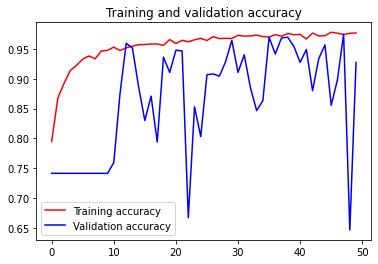

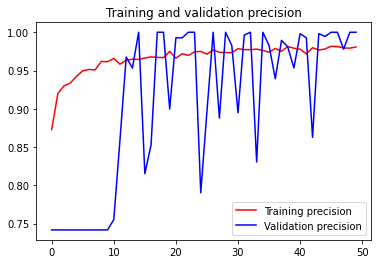

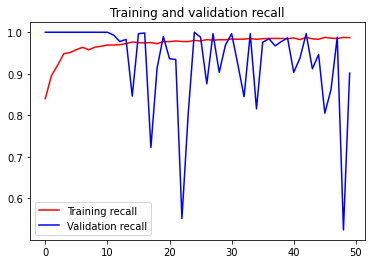

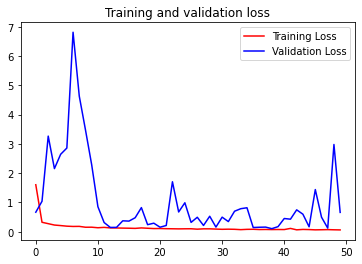

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
evaluation = model.evaluate(test_generator)

7/7 [==============================] - 282s 47s/step - loss: 0.1793 - accuracy: 0.9616 - precision: 0.9946 - recall: 0.9534 - true_positives_1: 553.0000 - true_negatives_1: 199.0000 - false_negatives_1: 27.0000 - false_positives_1: 3.0000


In [ ]:
# Nakon 50 epoha
print('Loss  :', evaluation[0])
print('Accuracy  :', evaluation[1])
print('Precision :', evaluation[2])
print('Recall :', evaluation[3])
print('True positives :', evaluation[4])
print('True negatives :', evaluation[5])
print('False negatives :', evaluation[6])
print('False positives :', evaluation[7])

Loss  : 0.16732405126094818
Accuracy  : 0.9744245409965515
Precision : 0.9929577708244324
Recall : 0.9724137783050537
True positives : 564.0
True negatives : 198.0
False negatives : 16.0
False positives : 4.0


# InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
pretrained_model=InceptionV3(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
for layers in pretrained_model.layers:
    layers.trainable=False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
last_layer=pretrained_model.get_layer('mixed10')
last_output = last_layer.output

In [ ]:
x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

model=tf.keras.Model(pretrained_model.input,x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall', tf.keras.metrics.TruePositives(), 
                       tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])
# model.summary()

In [ ]:
model_checkpoint = ModelCheckpoint('InceptionV3.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
csv_logger = CSVLogger("InceptionV3.csv")

In [ ]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(train_dir,target_size=(180,180),batch_size=128,class_mode='binary')

val_generator=val_datagen.flow_from_directory(val_dir,target_size=(180,180),batch_size=128,class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,target_size=(180,180),batch_size=128,class_mode='binary')

Found 4335 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [ ]:
history=model.fit(train_generator,validation_data=val_generator,epochs=50,verbose=2, callbacks=[CSVLogger("InceptionV3.csv"), model_checkpoint])

Epoch 1/50
34/34 - 999s - loss: 24.2442 - accuracy: 0.6865 - precision: 0.7747 - recall: 0.8011 - true_positives: 2521.0000 - true_negatives: 455.0000 - false_negatives: 626.0000 - false_positives: 733.0000 - val_loss: 0.2973 - val_accuracy: 0.8453 - val_precision: 0.8380 - val_recall: 0.9810 - val_true_positives: 569.0000 - val_true_negatives: 92.0000 - val_false_negatives: 11.0000 - val_false_positives: 110.0000

Epoch 00001: val_loss improved from inf to 0.29734, saving model to InceptionV3.h5
Epoch 2/50
34/34 - 79s - loss: 0.9644 - accuracy: 0.7532 - precision: 0.8175 - recall: 0.8497 - true_positives: 2674.0000 - true_negatives: 591.0000 - false_negatives: 473.0000 - false_positives: 597.0000 - val_loss: 0.3607 - val_accuracy: 0.8210 - val_precision: 0.8073 - val_recall: 0.9966 - val_true_positives: 578.0000 - val_true_negatives: 64.0000 - val_false_negatives: 2.0000 - val_false_positives: 138.0000

Epoch 00002: val_loss did not improve from 0.29734
Epoch 3/50
34/34 - 78s - loss: 

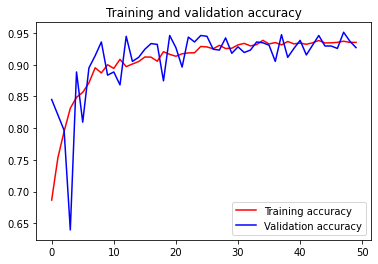

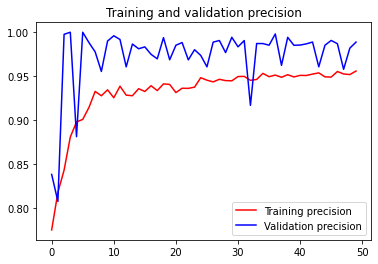

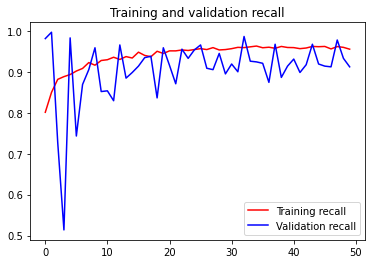

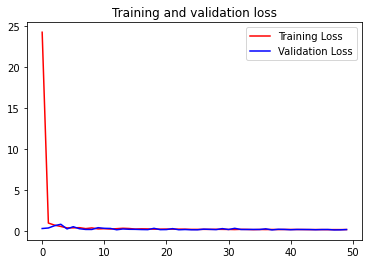

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



In [ ]:
evaluation = model.evaluate(test_generator)
print('Loss  :', evaluation[0])
print('Accuracy  :', evaluation[1])
print('Precision :', evaluation[2])
print('Recall :', evaluation[3])
print('True positives :', evaluation[4])
print('True negatives :', evaluation[5])
print('False negatives :', evaluation[6])
print('False positives :', evaluation[7])

7/7 [==============================] - 133s 22s/step - loss: 0.1719 - accuracy: 0.9386 - precision: 0.9926 - recall: 0.9241 - true_positives: 536.0000 - true_negatives: 198.0000 - false_negatives: 44.0000 - false_positives: 4.0000
Loss  : 0.17190653085708618
Accuracy  : 0.9386188983917236
Precision : 0.9925925731658936
Recall : 0.9241379499435425
True positives : 536.0
True negatives : 198.0
False negatives : 44.0
False positives : 4.0


# DenseNet121

In [ ]:
from keras.applications import DenseNet121

In [ ]:
pretrained_model=DenseNet121(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')
for layers in pretrained_model.layers:
    layers.trainable=False


29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
last_layer=pretrained_model.get_layer('conv5_block16_0_relu')
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

model=tf.keras.Model(pretrained_model.input,x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall', tf.keras.metrics.TruePositives(), 
                       tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])


In [ ]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(train_dir,target_size=(180,180),batch_size=128,class_mode='binary')

val_generator=val_datagen.flow_from_directory(val_dir,target_size=(180,180),batch_size=128,class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,target_size=(180,180),batch_size=128,class_mode='binary')

Found 4335 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [ ]:
model_checkpoint = ModelCheckpoint('DenseNet121.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
csv_logger = CSVLogger("DenseNet121.csv")


In [ ]:
history=model.fit(train_generator,validation_data=val_generator,epochs=50,verbose=2, callbacks=[CSVLogger("DenseNet121.csv"), model_checkpoint])

Epoch 1/50
34/34 - 1263s - loss: 0.8192 - accuracy: 0.7278 - precision: 0.7730 - recall: 0.8850 - true_positives: 2785.0000 - true_negatives: 370.0000 - false_negatives: 362.0000 - false_positives: 818.0000 - val_loss: 0.2889 - val_accuracy: 0.8286 - val_precision: 0.8159 - val_recall: 0.9931 - val_true_positives: 576.0000 - val_true_negatives: 72.0000 - val_false_negatives: 4.0000 - val_false_positives: 130.0000

Epoch 00001: val_loss improved from inf to 0.28886, saving model to DenseNet121.h5
Epoch 2/50
34/34 - 78s - loss: 0.3166 - accuracy: 0.8648 - precision: 0.8953 - recall: 0.9215 - true_positives: 2900.0000 - true_negatives: 849.0000 - false_negatives: 247.0000 - false_positives: 339.0000 - val_loss: 0.1914 - val_accuracy: 0.9220 - val_precision: 0.9289 - val_recall: 0.9690 - val_true_positives: 562.0000 - val_true_negatives: 159.0000 - val_false_negatives: 18.0000 - val_false_positives: 43.0000

Epoch 00002: val_loss improved from 0.28886 to 0.19145, saving model to DenseNet12

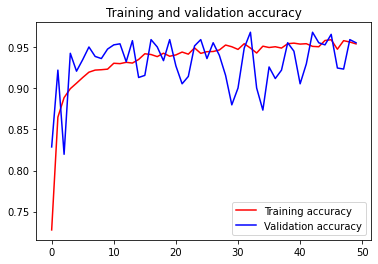

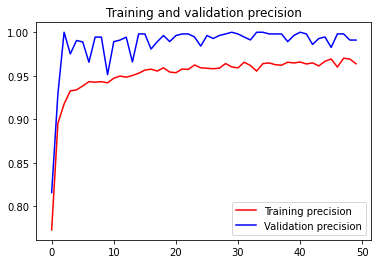

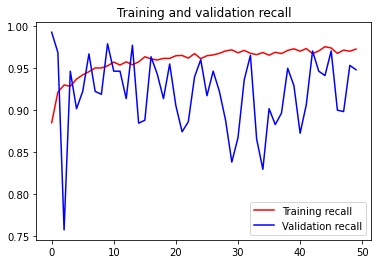

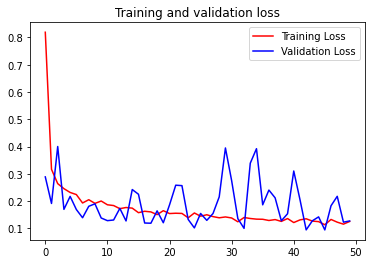

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
evaluation = model.evaluate(test_generator)
print('Loss  :', evaluation[0])
print('Accuracy  :', evaluation[1])
print('Precision :', evaluation[2])
print('Recall :', evaluation[3])
print('True positives :', evaluation[4])
print('True negatives :', evaluation[5])
print('False negatives :', evaluation[6])
print('False positives :', evaluation[7])

7/7 [==============================] - 144s 24s/step - loss: 0.1002 - accuracy: 0.9731 - precision: 0.9947 - recall: 0.9690 - true_positives: 562.0000 - true_negatives: 199.0000 - false_negatives: 18.0000 - false_positives: 3.0000
Loss  : 0.10018554329872131
Accuracy  : 0.9731457829475403
Precision : 0.9946902394294739
Recall : 0.9689655303955078
True positives : 562.0
True negatives : 199.0
False negatives : 18.0
False positives : 3.0


# VGG19

In [7]:
from keras.applications import VGG19

In [8]:
pretrained_model = VGG19(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')

for layers in pretrained_model.layers:
    layers.trainable=False

pretrained_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
______________________________________________________________

In [9]:
last_layer = pretrained_model.get_layer('block5_conv4')
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(pretrained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall', tf.keras.metrics.TruePositives(), 
                       tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

In [10]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(180,180),batch_size=128,class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,target_size=(180,180),batch_size=128,class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(180,180),batch_size=128,class_mode='binary')

Found 4335 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [11]:
model_checkpoint = ModelCheckpoint('VGG19.h5', monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger("VGG19.csv")

In [12]:
history = model.fit(train_generator,validation_data = val_generator,epochs = 50,verbose = 2, callbacks=[CSVLogger("VGG19.csv"), model_checkpoint])

Epoch 1/50
34/34 - 2586s - loss: 7.2113 - accuracy: 0.6812 - precision: 0.7813 - recall: 0.7788 - true_positives: 2451.0000 - true_negatives: 502.0000 - false_negatives: 696.0000 - false_positives: 686.0000 - val_loss: 0.3775 - val_accuracy: 0.8504 - val_precision: 0.9853 - val_recall: 0.8103 - val_true_positives: 470.0000 - val_true_negatives: 195.0000 - val_false_negatives: 110.0000 - val_false_positives: 7.0000

Epoch 00001: val_loss improved from inf to 0.37748, saving model to VGG19.h5
Epoch 2/50
34/34 - 78s - loss: 0.6276 - accuracy: 0.7790 - precision: 0.8430 - recall: 0.8548 - true_positives: 2690.0000 - true_negatives: 687.0000 - false_negatives: 457.0000 - false_positives: 501.0000 - val_loss: 1.0388 - val_accuracy: 0.7417 - val_precision: 0.7417 - val_recall: 1.0000 - val_true_positives: 580.0000 - val_true_negatives: 0.0000e+00 - val_false_negatives: 0.0000e+00 - val_false_positives: 202.0000

Epoch 00002: val_loss did not improve from 0.37748
Epoch 3/50
34/34 - 78s - loss:

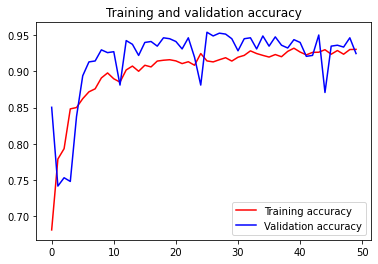

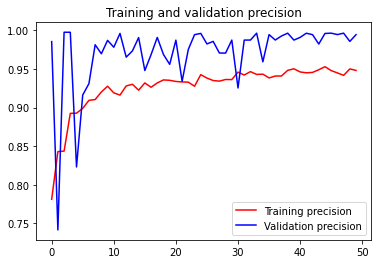

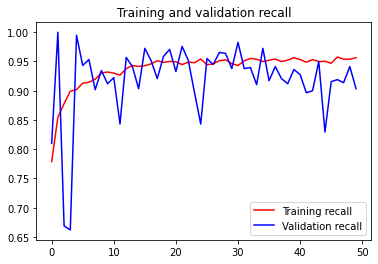

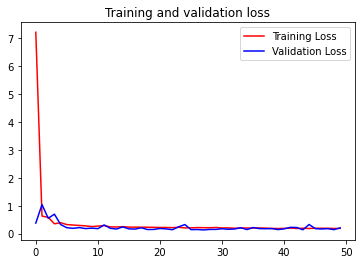

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
evaluation = model.evaluate(test_generator)
print('Loss  :', evaluation[0])
print('Accuracy  :', evaluation[1])
print('Precision :', evaluation[2])
print('Recall :', evaluation[3])
print('True positives :', evaluation[4])
print('True negatives :', evaluation[5])
print('False negatives :', evaluation[6])
print('False positives :', evaluation[7])

7/7 [==============================] - 10s 1s/step - loss: 0.1760 - accuracy: 0.9514 - precision: 0.9609 - recall: 0.9741 - true_positives_4: 565.0000 - true_negatives_4: 179.0000 - false_negatives_4: 15.0000 - false_positives_4: 23.0000
Loss  : 0.17602519690990448
Accuracy  : 0.9514066576957703
Precision : 0.9608843326568604
Recall : 0.9741379022598267
True positives : 565.0
True negatives : 179.0
False negatives : 15.0
False positives : 23.0


In [14]:
#napokon
evaluation = model.evaluate(test_generator)
print('Loss  :', evaluation[0])
print('Accuracy  :', evaluation[1])
print('Precision :', evaluation[2])
print('Recall :', evaluation[3])
print('True positives :', evaluation[4])
print('True negatives :', evaluation[5])
print('False negatives :', evaluation[6])
print('False positives :', evaluation[7])

7/7 [==============================] - 332s 55s/step - loss: 0.1958 - accuracy: 0.9297 - precision: 0.9962 - recall: 0.9086 - true_positives: 527.0000 - true_negatives: 200.0000 - false_negatives: 53.0000 - false_positives: 2.0000
Loss  : 0.19576068222522736
Accuracy  : 0.9296675324440002
Precision : 0.996219277381897
Recall : 0.9086207151412964
True positives : 527.0
True negatives : 200.0
False negatives : 53.0
False positives : 2.0


# MobileNet

In [15]:
from keras.applications import MobileNet

In [16]:
pretrained_model = MobileNet(input_shape=(180,180,3),
                             include_top=False,
                             weights='imagenet')

for layers in pretrained_model.layers:
    layers.trainable=False

pretrained_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 90, 90, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 90, 90, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 90, 90, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 90, 90, 32)        128       
_________________________________________________

In [18]:
last_layer = pretrained_model.get_layer('conv_pw_13_relu')
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2,activation='softmax')(x)

model = tf.keras.Model(pretrained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall', tf.keras.metrics.TruePositives(), 
                       tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

In [19]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(180,180),batch_size=128)

val_generator = val_datagen.flow_from_directory(val_dir,target_size=(180,180),batch_size=128)

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(180,180),batch_size=128)

Found 4335 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [20]:
history = model.fit(train_generator,validation_data = val_generator,epochs = 50,verbose = 2)

Epoch 1/50
34/34 - 81s - loss: 11.6638 - accuracy: 0.8129 - precision: 0.8129 - recall: 0.8129 - true_positives_2: 3524.0000 - true_negatives_2: 3524.0000 - false_negatives_2: 811.0000 - false_positives_2: 811.0000 - val_loss: 0.1547 - val_accuracy: 0.9335 - val_precision: 0.9335 - val_recall: 0.9335 - val_true_positives_2: 730.0000 - val_true_negatives_2: 730.0000 - val_false_negatives_2: 52.0000 - val_false_positives_2: 52.0000
Epoch 2/50
34/34 - 76s - loss: 0.5927 - accuracy: 0.8397 - precision: 0.8397 - recall: 0.8397 - true_positives_2: 3640.0000 - true_negatives_2: 3640.0000 - false_negatives_2: 695.0000 - false_positives_2: 695.0000 - val_loss: 0.3171 - val_accuracy: 0.8785 - val_precision: 0.8785 - val_recall: 0.8785 - val_true_positives_2: 687.0000 - val_true_negatives_2: 687.0000 - val_false_negatives_2: 95.0000 - val_false_positives_2: 95.0000
Epoch 3/50
34/34 - 75s - loss: 0.5478 - accuracy: 0.8621 - precision: 0.8621 - recall: 0.8621 - true_positives_2: 3737.0000 - true_ne

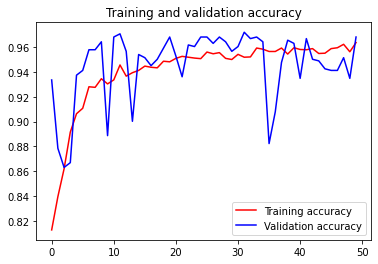

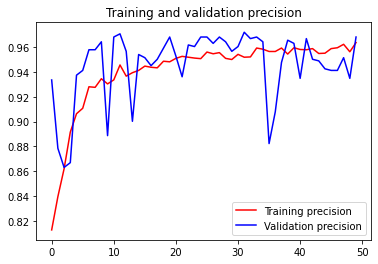

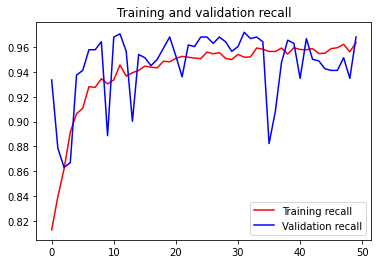

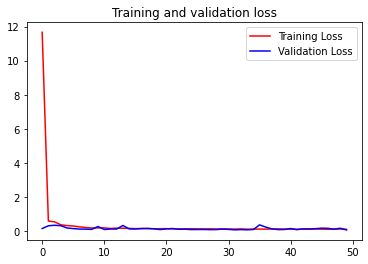

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
evaluation = model.evaluate(test_generator)
print('Loss  :', evaluation[0])
print('Accuracy  :', evaluation[1])
print('Precision :', evaluation[2])
print('Recall :', evaluation[3])
print('True positives :', evaluation[4])
print('True negatives :', evaluation[5])
print('False negatives :', evaluation[6])
print('False positives :', evaluation[7])

7/7 [==============================] - 7s 1s/step - loss: 0.0999 - accuracy: 0.9783 - precision: 0.9783 - recall: 0.9783 - true_positives_2: 765.0000 - true_negatives_2: 765.0000 - false_negatives_2: 17.0000 - false_positives_2: 17.0000
Loss  : 0.09993147104978561
Accuracy  : 0.97826087474823
Precision : 0.97826087474823
Recall : 0.97826087474823
True positives : 765.0
True negatives : 765.0
False negatives : 17.0
False positives : 17.0


In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 112kB 23.3MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
import time 
saved_model_path = "/tmp/saved_models/{}".format(int(time.time()))
model.save(saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_models/1612132490/assets


In [ ]:
!tensorflowjs_converter \
  --input_format=keras_saved_model \
  /tmp/saved_models/1612132490 \
  /tmp/linear

2021-01-31 22:35:17.738770: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-31 22:35:19.382988: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-31 22:35:19.383967: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-31 22:35:19.388704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-31 22:35:19.389220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-01-31 22:35:19.389262: I tensorflow/stream_executor/platform/default/dso_loade